In [14]:
import tensorflow as tf
from sklearn.metrics import classification_report
import seaborn as sns;sns.set()
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np

### Cargamos los mejores modelos serializados

* Primero cargamos la funcion personalizada usada para la perdida focal, esta es importante para realizar la evaluacion del modelo

In [2]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002
        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]
        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})
        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [3]:
path_model_weighted="../input/modelosfinales/tranferlearning_densenet169_with_balanced_focal_loss_3_class_equalized_wgt.h5"
path_model_focal="../input/modelosfinales/tranferlearning_densenet169_with_balanced_focal_loss_3_class_equalized.h5"

model_transfer_class_weight=tf.keras.models.load_model(path_model_weighted)
model_transfer_focal_loss=tf.keras.models.load_model(path_model_focal, custom_objects={'focal_loss_fixed': focal_loss()})

In [4]:
model_transfer_class_weight.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
flatten_1 (Flatten)          (None, 106496)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 106496)            425984    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               27263232  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024

In [5]:
model_transfer_focal_loss.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 8, 8, 1664)        12642880  
_________________________________________________________________
flatten_1 (Flatten)          (None, 106496)            0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 106496)            425984    
_________________________________________________________________
dense_3 (Dense)              (None, 256)               27263232  
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024

### Cargamos el flujo de datos de TEST

* A traves de la libreria

In [6]:
path_test="../input/datasettestcovid19/test"
IMAGE_SIZE=(256,256)
test_datagen=ImageDataGenerator(rescale=1.0/255)
test_generator=test_datagen.flow_from_directory(
            path_test,
            target_size=IMAGE_SIZE,
            batch_size=32,
            shuffle=False,
            class_mode="categorical"
)

Found 4233 images belonging to 3 classes.


In [7]:
test_generator.class_indices

{'COVID': 0, 'Enfermedades Pulmonares No COVID19': 1, 'Normal': 2}

In [8]:
test_generator.reset()

In [9]:
model_transfer_class_weight.evaluate(test_generator)

133/133 [==============================] - 36s 201ms/step - loss: 0.2244 - accuracy: 0.9213 - recall: 0.9178


[0.22444237768650055, 0.9213323593139648, 0.9177888035774231]

In [10]:
test_generator.reset()

In [11]:
model_transfer_focal_loss.evaluate(test_generator)

133/133 [==============================] - 19s 120ms/step - loss: 0.2670 - accuracy: 0.9242 - recall: 0.9187


[0.26700618863105774, 0.924167275428772, 0.9187337756156921]

* Y efectivamente el modelo que logro una mayor precision fue el Transferencia de informacion con un accuracy de 92.42% de aciertos en datos **NUNCA ANTES VISTOS**.

Elaboremos su matriz de clasificación.

In [15]:
test_generator.reset()

In [16]:
y_true=test_generator.classes
predictions=model_transfer_focal_loss.predict(test_generator)
y_pred=np.argmax(predictions,axis=1)

In [20]:
test_generator.class_indices

{'COVID': 0, 'Enfermedades Pulmonares No COVID19': 1, 'Normal': 2}

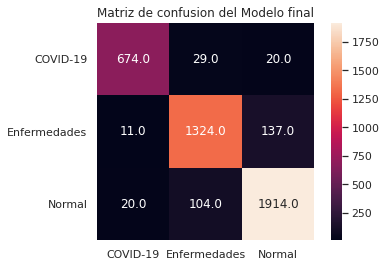

In [23]:
target_names={"COVID-19":0,"Enfermedades":1,"Normal":2}#test_generator.class_indices
mat=confusion_matrix(y_true,y_pred)


sns.heatmap(mat,annot=True,fmt="0.1f",square=True,xticklabels=target_names,yticklabels=target_names)
plt.title("Matriz de confusion del Modelo final")
plt.show()

In [18]:
report=classification_report(y_true,y_pred,target_names=target_names)
print(report)

                                    precision    recall  f1-score   support

                             COVID       0.96      0.93      0.94       723
Enfermedades Pulmonares No COVID19       0.91      0.90      0.90      1472
                            Normal       0.92      0.94      0.93      2038

                          accuracy                           0.92      4233
                         macro avg       0.93      0.92      0.93      4233
                      weighted avg       0.92      0.92      0.92      4233



* El modelo escogido tendra que ser transformado un formato js para su despliegue